In [1]:
import sys
from pathlib import Path

# Get the custom-made module directory
current_dir = Path.cwd()
sys.path.append(str(current_dir.parent.parent.parent / "code" / "Pulser_implementation"))

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from tqdm import tqdm

# Import our image processing utilities
from graphs.image_to_graph import load_image, extract_lbp_features, extract_glcm_features
from visualization.visualization import plot_confusion_matrix

from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from skimage.measure import regionprops
from skimage.segmentation import slic

In [2]:
# Specify the directories 
data_root = os.path.join(Path.cwd().parent.parent.parent, "data", "Pulser_implementation", "dataset")
no_polyp_dir = os.path.join(data_root, "no_polyp")
polyp_dir = os.path.join(data_root, "polyp")
print(f"Loading data from:\n- No polyp: {no_polyp_dir}\n- Polyp: {polyp_dir}")

Loading data from:
- No polyp: /home/nuno/Documents/GIC-quAI-Pasqal-Quantum-Evolution-Kernel/data/Pulser_implementation/dataset/no_polyp
- Polyp: /home/nuno/Documents/GIC-quAI-Pasqal-Quantum-Evolution-Kernel/data/Pulser_implementation/dataset/polyp


In [ ]:
# Parameters
MAX_SAMPLES_PER_CLASS = 200
N_SEGMENTS = 20  # Same as N_QUBITS in quantum version

In [4]:
def extract_image_features(img_path, n_segments=20):
    """Extract classical features from an image without creating a quantum graph"""
    # Load image
    image = load_image(img_path)
    
    # Convert to grayscale
    if len(image.shape) == 3:
        gray = rgb2gray(image)
    else:
        gray = image
    
    # Extract global features
    # 1. LBP histogram
    lbp = extract_lbp_features(gray)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=10, range=(0, 26), density=True)
    
    # 2. GLCM features
    glcm_features = extract_glcm_features(gray)
    glcm_vector = np.array([
        glcm_features['contrast'], 
        glcm_features['dissimilarity'],
        glcm_features['homogeneity'], 
        glcm_features['energy'],
        glcm_features['correlation'], 
        glcm_features['ASM']
    ])
    
    # 3. Segment the image into regions and extract features per region
    segments = slic(image, n_segments=n_segments, compactness=10)
    regions = regionprops(segments + 1)
    
    region_features = []
    for region in regions:
        # Get region mask
        coords = region.coords
        mask = np.zeros(segments.shape, dtype=bool)
        mask[coords[:, 0], coords[:, 1]] = True
        
        # Extract color features
        if len(image.shape) == 3:
            mean_color = np.mean(image[mask], axis=0)
            std_color = np.std(image[mask], axis=0)
        else:
            mean_color = np.array([np.mean(image[mask])])
            std_color = np.array([np.std(image[mask])])
        
        # Extract texture features from this region
        region_lbp = lbp[mask]
        region_lbp_hist, _ = np.histogram(region_lbp, bins=5, density=True)
        
        # Add area and eccentricity as shape features
        area = region.area / segments.size  # normalized area
        eccentricity = region.eccentricity
        
        # Combine features for this region
        region_feat = np.concatenate([
            mean_color.flatten(), 
            std_color.flatten(),
            region_lbp_hist,
            [area, eccentricity]
        ])
        region_features.append(region_feat)
    
    # Ensure we have n_segments regions by padding or truncating
    if len(region_features) > n_segments:
        region_features = region_features[:n_segments]
    elif len(region_features) < n_segments:
        # Pad with zeros
        feature_len = len(region_features[0]) if region_features else (3*2 + 5 + 2)  # Default size
        padding = [np.zeros(feature_len) for _ in range(n_segments - len(region_features))]
        region_features.extend(padding)
    
    # Flatten all region features
    flattened_regions = np.concatenate(region_features)
    
    # Combine all features
    features = np.concatenate([lbp_hist, glcm_vector, flattened_regions])
    
    return features

In [5]:
# Load and process the dataset
def load_dataset(max_samples=200):
    no_polyp_samples = []
    polyp_samples = []
    
    # Process No Polyp images
    no_polyp_files = os.listdir(no_polyp_dir)[:max_samples]
    for file in tqdm(no_polyp_files, desc="Processing No Polyp Images"):
        try:
            features = extract_image_features(os.path.join(no_polyp_dir, file), N_SEGMENTS)
            no_polyp_samples.append((features, 0))  # 0 for no polyp
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
    
    # Process Polyp images
    polyp_files = os.listdir(polyp_dir)[:max_samples]
    for file in tqdm(polyp_files, desc="Processing Polyp Images"):
        try:
            features = extract_image_features(os.path.join(polyp_dir, file), N_SEGMENTS)
            polyp_samples.append((features, 1))  # 1 for polyp
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
    
    # Combine samples
    all_samples = no_polyp_samples + polyp_samples
    
    # Extract features and labels
    X = np.array([sample[0] for sample in all_samples])
    y = np.array([sample[1] for sample in all_samples])
    
    print(f"\nDataset created with {len(X)} samples:")
    print(f"- No Polyp: {len(no_polyp_samples)}")
    print(f"- Polyp: {len(polyp_samples)}")
    print(f"- Feature dimension: {X.shape[1]}")
    
    return X, y


In [6]:
# Load the dataset
X, y = load_dataset(max_samples=MAX_SAMPLES_PER_CLASS)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Class distribution - Training: No polyp: {np.sum(y_train == 0)}, Polyp: {np.sum(y_train == 1)}")
print(f"Class distribution - Testing: No polyp: {np.sum(y_test == 0)}, Polyp: {np.sum(y_test == 1)}")

Processing Polyp Images: 100%|██████████| 200/200 [00:22<00:00,  8.73it/s]


Dataset created with 400 samples:
- No Polyp: 200
- Polyp: 200
- Feature dimension: 666
Training set size: 320
Testing set size: 80
Class distribution - Training: No polyp: 160, Polyp: 160
Class distribution - Testing: No polyp: 40, Polyp: 40


In [7]:
# Create a pipeline with StandardScaler, PCA, and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=min(100, X_train.shape[0], X_train.shape[1]), random_state=42)),
    ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42))
])

In [8]:
# Train the model
print("\nTraining the classical SVM model...")
pipeline.fit(X_train, y_train)


Training the classical SVM model...


Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=100, random_state=42)),
                ('svm',
                 SVC(class_weight='balanced', probability=True,
                     random_state=42))])

In [9]:
# Make predictions
print("Making predictions on test set...")
y_pred = pipeline.predict(X_test)

Making predictions on test set...



Evaluation Results:
F1 Score: 0.575
Balanced Accuracy Score: 0.575

Confusion Matrix:


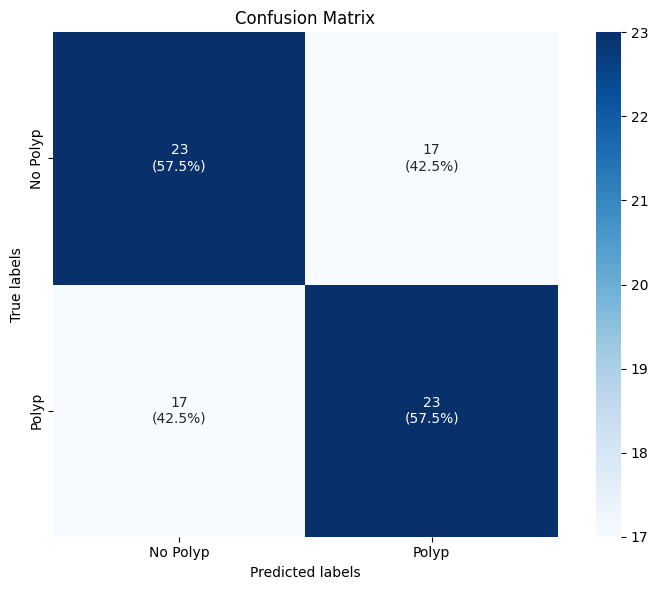

[[23 17]
 [17 23]]

Classification Report:
              precision    recall  f1-score   support

    No Polyp       0.57      0.57      0.57        40
       Polyp       0.57      0.57      0.57        40

    accuracy                           0.57        80
   macro avg       0.57      0.57      0.57        80
weighted avg       0.57      0.57      0.57        80



In [ ]:
# Evaluate the model
print("\nEvaluation Results:")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")
print("\nConfusion Matrix:")
#plot_confusion_matrix(y_test, y_pred, ['No Polyp', 'Polyp'])
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Polyp', 'Polyp']))

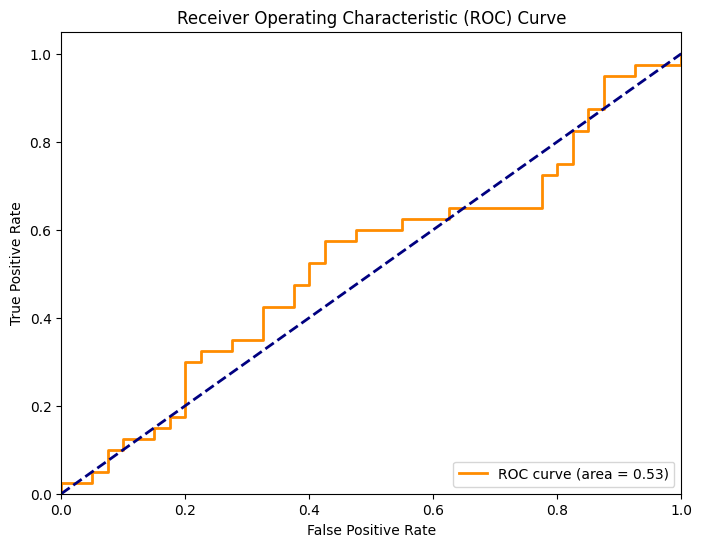

In [11]:
# Plot ROC curve for the SVM model
from sklearn.metrics import roc_curve, auc

# Get probability predictions
y_score = pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('classical_svm_roc_curve.png')
plt.show()

In [12]:
# Feature importance analysis
pca = pipeline.named_steps['pca']
print(f"\nVariance explained by PCA components: {np.sum(pca.explained_variance_ratio_):.2f}")
print(f"Number of components used: {pca.n_components_}")

# Compare with SVM feature importance (for linear kernel only)
if pipeline.named_steps['svm'].kernel == 'linear':
    svm_weights = np.abs(pipeline.named_steps['svm'].coef_[0])
    pca_components = pipeline.named_steps['pca'].components_
    feature_importance = np.sum(svm_weights.reshape(-1, 1) * np.abs(pca_components), axis=0)
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.title('Feature Importance (Linear SVM)')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.savefig('classical_svm_feature_importance.png')
    plt.show()

print("\nClassical analysis complete!")


Variance explained by PCA components: 0.97
Number of components used: 100

Classical analysis complete!
